<a href="https://colab.research.google.com/github/Vaelastraszz/Computer_Vision_2/blob/master/Class_activation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import keras
from keras.models import load_model
from keras.models import Model

In [3]:
import scipy as sp
from keras import backend as K

In [4]:
model = load_model('/content/gdrive/My Drive/tomato/tuned_model.h5')

In [5]:
from keras.preprocessing import image

def proc_img(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_tensor = image.img_to_array(img) # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0) 
    img_tensor /= 255.
 
    return img_tensor

# Récupération de la dernière couche d'activation du modèle

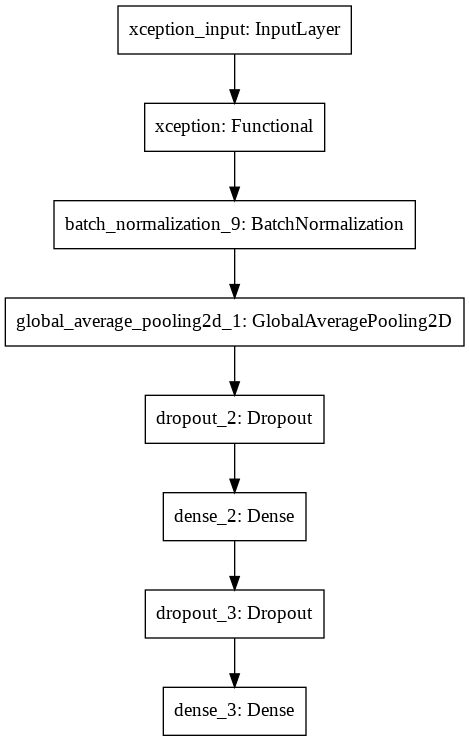

In [6]:
from keras.utils import plot_model
plot_model(model)

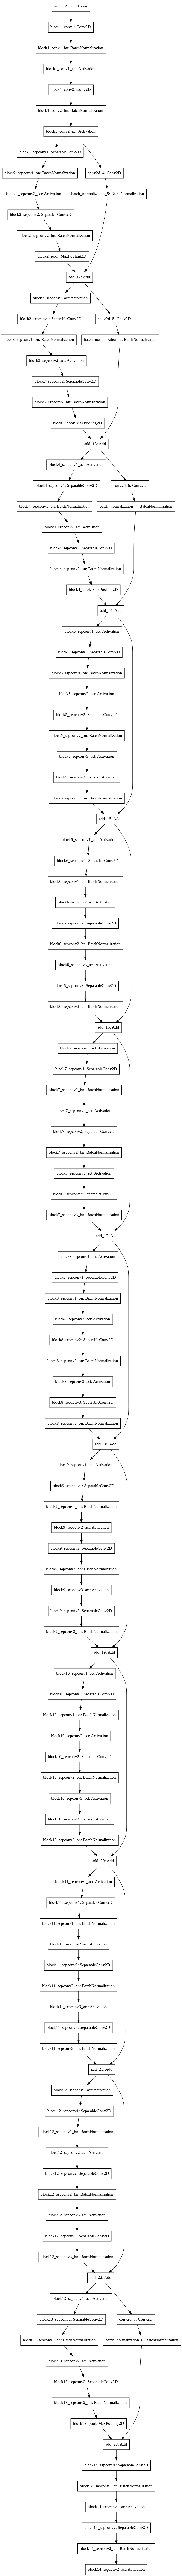

In [8]:
plot_model(model.get_layer('xception'))

#Génération des class activations map

In [6]:
xcp = model.get_layer('xception')
last_conv_layer = xcp.get_layer('block14_sepconv2_act')

In [7]:
or_img = proc_img('/content/gdrive/My Drive/tomato/test.jpg')

In [8]:
cut_model = Model(inputs = xcp.input, outputs = last_conv_layer.output)

In [20]:
class_weight = model.layers[-3].get_weights()[0]

In [22]:
class_weight_last = model.layers[-1].get_weights()[0]

In [10]:
conv_output = cut_model.predict(or_img)
conv_output = conv_output[0,:,:,:]

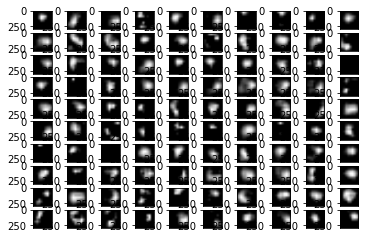

In [53]:
from matplotlib import pyplot

for idx in range(100) :
    ax = pyplot.subplot(10, 10, idx+1)
    ax.set_xticks([])
    pyplot.imshow(cam_features[:,:,idx], cmap='gray')
pyplot.show()

In [23]:
output_1 = np.dot(conv_output, class_weight)

In [24]:
final_output = np.dot(output_1, class_weight_last)

In [29]:
cam_features = sp.ndimage.zoom(final_output, (29.9, 29.9, 1), order=1).reshape(299,299)

In [13]:
import matplotlib.pyplot as plt

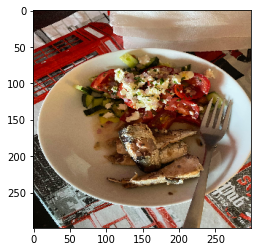

In [15]:
plt.imshow(or_img[0])

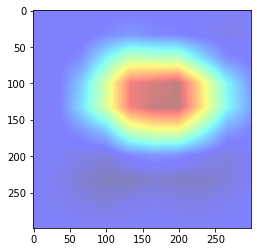

In [30]:
plt.imshow(cam_features, cmap='jet', alpha=0.5)

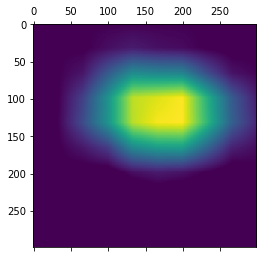

In [103]:
heatmap = np.maximum(cam_features, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

# Display de la cam 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


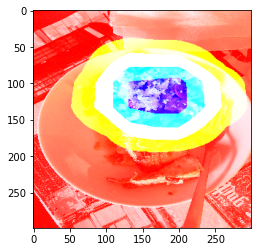

In [104]:
import cv2

img = np.uint8(255 * or_img[0])
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
merged=  heatmap * 0.5  + or_img[0]
plt.imshow(merged)

# Creation de classe génératrice de CAM

In [109]:
import keras
from keras.models import load_model
from keras.models import Model
import scipy as sp
from keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2


path_model = '/content/gdrive/My Drive/tomato/tuned_model.h5'

class CAM_gen:

    def __init__(self):
        self.model = load_model(path_model)
        self.xcp = self.model.get_layer('xception')
        self.last_conv_layer = self.xcp.get_layer('block14_sepconv2_act')
        self.cut_model = Model(inputs = self.xcp.input, outputs = self.last_conv_layer.output)
        self.class_weight = self.model.layers[-3].get_weights()[0]
        self.class_weight_last = self.model.layers[-1].get_weights()[0]
        self.img_path=""
        self.img = None
 
    def proc_img(self, img_path):

        img = image.load_img(img_path, target_size=(299, 299))
        img_tensor = image.img_to_array(img) # (height, width, channels)
        img_tensor = np.expand_dims(img_tensor, axis=0) 
        img_tensor /= 255.

        return img_tensor

    def get_CAM(self, img_path):

        or_img = self.proc_img(img_path)
        self.img = or_img[0]
        self.img_path = img_path
        conv_output = self.cut_model.predict(or_img)
        conv_output = conv_output[0,:,:,:]
        output_1 = np.dot(conv_output, self.class_weight)
        final_output = np.dot(output_1, self.class_weight_last)
        cam_features = sp.ndimage.zoom(final_output, (29.9, 29.9, 1), order=1).reshape(299,299)

        return cam_features

    def plot_CAM(self, cam_features):

        heatmap = np.maximum(cam_features, 0)
        heatmap /= np.max(heatmap)


        img = np.uint8(255 * self.img)
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        merged=  self.img + heatmap * 0.5  
        plt.imshow(merged)


In [110]:
test = CAM_gen()

In [111]:
cam_test = test.get_CAM("/content/gdrive/My Drive/tomato/test.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


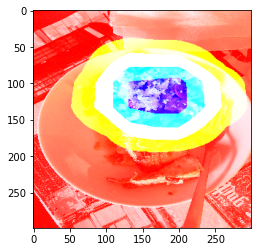

In [112]:
test.plot_CAM(cam_test)